## Setup

In [18]:
%matplotlib inline

In [19]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [20]:
from aif360.datasets import StandardDataset
StandardDataset??

In [21]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [22]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'bank', 'meps19', 'grade', 'law_sex', 'german_age'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [23]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [24]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [25]:
DATASET = "german_age"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [26]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [27]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: credit, Length: 1000, dtype: int64


In [28]:
dataset_orig.features.shape

(1000, 57)

In [29]:
privileged_groups

[{'age': 1}]

In [30]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[3.000e+01 4.811e+03 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [9.000e+00 1.337e+03 4.000e+00 ... 1.000e+00 1.000e+00 0.000e+00]
 [1.500e+01 2.360e+03 2.000e+00 ... 1.000e+00 1.000e+00 0.000e+00]
 ...
 [2.100e+01 5.710e+02 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [3.000e+01 2.503e+03 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.400e+01 1.282e+03 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]


In [31]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [32]:
dataset_orig_train

               instance weights features                \
                                                         
                                   month credit_amount   
instance names                                           
306                         1.0     30.0        4811.0   
720                         1.0      9.0        1337.0   
506                         1.0     15.0        2360.0   
188                         1.0     12.0         674.0   
741                         1.0     10.0        1048.0   
...                         ...      ...           ...   
756                         1.0      6.0        1299.0   
638                         1.0     12.0        1493.0   
179                         1.0     21.0         571.0   
703                         1.0     30.0        2503.0   
15                          1.0     24.0        1282.0   

                                                                \
                                                               

In [33]:
dataset_orig_train?

## Run Mitigating Algorithms

In [34]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[1.2000e+01 2.1710e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2000e+01 3.0770e+03 2.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [2.4000e+01 1.9350e+03 4.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [3.0000e+01 1.1998e+04 1.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [2.4000e+01 1.9250e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.2000e+01 1.1850e+03 3.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]
no bias type specified
#### Training Dataset shape
(500, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'st

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.26
  Positive predictive value: 0.60
  Optimal thershold: -0.40546510810816444
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 149, Test = 151
  AUC: 0.75
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.39
  Positive predictive value: 0.71
  Optimal thershold: -1.0116009116784799
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 351, Test = 349
  AUC: 0.61
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.21
  Positive predictive value: 0.57
  Optimal thershold: -0.40546510810816444
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 26, Test = 35
  AUC:

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 26
Number of test samples (ntest): 35
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 44
Number of test samples (ntest): 44
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 123
Number of test samples (ntest): 116
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 307
Number of test samples (ntest): 305
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.22
  Positive predictive value: 0.58
  Optimal thershold: -0.5212969236332861
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 149, Test = 151
  AUC: 0.72
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.33
  Positive predictive value: 0.66
  O

Accuracy for threshold: 0.44  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.45  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.46  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.47000000000000003  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.48000000000000004  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.49  is: 0.66
Balanced accuracy is:  0.5873735744511281
Accuracy for threshold: 0.5  is: 0.66
Balanced accuracy is:  0.5873735744511281
Best thresh:  0.38
Best balanced accuracy: 0.5874
Corresponding 1-min(DI, 1/DI) value: 0.9641
Corresponding average odds difference value: 0.0149
Corresponding statistical parity difference value: -0.0259
Corresponding equal opportunity difference value: -0.0498
Corresponding Theil index value: 0.2248
Corresponding false positive_rate for privileged: 0.5776
Corresponding false negative_rate for privil

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.02  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.03  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.04  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.05  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.060000000000000005  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.06999999999999999  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.08  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.09  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.09999999999999999  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.11  is: 0.35
Balanced accuracy is:  0.36906772424524187
Accuracy for threshold: 0.12  is: 0.35


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Best balanced accuracy: 0.5221
Corresponding 1-min(DI, 1/DI) value: 0.7342
Corresponding average odds difference value: -0.2708
Corresponding statistical parity difference value: -0.2658
Corresponding equal opportunity difference value: -0.2273
Corresponding Theil index value: 0.0770
Corresponding false positive_rate for privileged: 1.0000
Corresponding false negative_rate for privileged: 0.0000
Corresponding false positive_rate for unpribileged: 0.6857
Corresponding false negative_rate for unprivileged: 0.2273
#### Train dataset's features are as below:
[[1.8000e+01 1.2950e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.7000e+01 5.1900e+03 4.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [5.4000e+01 1.5945e+04 3.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [2.7000e+01 2.5280e+03 4.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [1.2000e+01 3.0590e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.6000e+01 8.1330e+03 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+

Accuracy for threshold: 0.15000000000000002  is: 0.682
Balanced accuracy is:  0.6144807430538874
Accuracy for threshold: 0.16  is: 0.682
Balanced accuracy is:  0.6144807430538874
Accuracy for threshold: 0.17  is: 0.682
Balanced accuracy is:  0.6144807430538874
Accuracy for threshold: 0.18000000000000002  is: 0.682
Balanced accuracy is:  0.6144807430538874
Accuracy for threshold: 0.19  is: 0.682
Balanced accuracy is:  0.6144807430538874
Accuracy for threshold: 0.2  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.21000000000000002  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.22  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.23  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.24000000000000002  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.25  is: 0.688
Balanced accuracy is:  0.6365601729521979
Accuracy for threshold: 0.26  is: 0.688

Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 313
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.29
  Positive predictive value: 0.59
  Optimal thershold: -0.5985230268660566
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.75
  Privacy Risk: 0.73
  Accuracy: 0.75
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.47
  Positive predictive value: 0.71
  Optimal thershold: -1.5938866846040753
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 338, Test = 362
  AUC: 0.61
  Privacy Risk: 0.61
  Accuracy: 0.60
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.23
  Positive predictive value: 0.55
  Optimal thershold: -0.51448935

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.02  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.03  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.04  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.05  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.060000000000000005  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.06999999999999999  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.08  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.09  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.09999999999999999  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.11  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.12  is: 0.382

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 30
Number of test samples (ntest): 31
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 39
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 132
Number of test samples (ntest): 107
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 313
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.73
  Privacy Risk: 0.72
  Accuracy: 0.72
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.44
  Positive predictive value: 0.65
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.83
  Privacy Risk: 0.81
  Accuracy: 0.82
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.62
  Positive predictive value: 0.80


Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 313
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.64
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.28
  Positive predictive value: 0.59
  Optimal thershold: -0.30010459245033816
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.79
  Privacy Risk: 0.74
  Accuracy: 0.76
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.48
  Positive predictive value: 0.77
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 338, Test = 362
  AUC: 0.59
  Privacy Risk: 0.60
  Accuracy: 0.59
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.21
  Positive predictive value: 0.55
  Optimal thershold: -0.1335313

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93       162
         1.0       0.98      0.95      0.97       338

    accuracy                           0.96       500
   macro avg       0.94      0.96      0.95       500
weighted avg       0.96      0.96      0.96       500

Train accuracy:  0.956
Validating Original ...
Accuracy for threshold: 0.01  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.02  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.03  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.04  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.05  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.060000000000000005  is: 0.702
Balanced accuracy is:  0.5722435743454239
Accuracy for threshold: 0.06999999

Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 313
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.65
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.29
  Positive predictive value: 0.59
  Optimal thershold: -0.5985230268660566
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.75
  Privacy Risk: 0.73
  Accuracy: 0.75
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.47
  Positive predictive value: 0.71
  Optimal thershold: -1.5938866846040753
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 338, Test = 362
  AUC: 0.61
  Privacy Risk: 0.61
  Accuracy: 0.60
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.23
  Positive predictive value: 0.55
  Optimal thershold: -0.51448935

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.02  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.03  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.04  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.05  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.060000000000000005  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.06999999999999999  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.08  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.09  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.09999999999999999  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.11  is: 0.382
Balanced accuracy is:  0.3512490992073024
Accuracy for threshold: 0.12  is: 0.382

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.73
  Privacy Risk: 0.72
  Accuracy: 0.72
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.44
  Positive predictive value: 0.65
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.83
  Privacy Risk: 0.81
  Accuracy: 0.82
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.62
  Positive predictive value: 0.80
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 338, Test = 362
  AUC: 0.69
  Privacy Risk: 0.69
  Accuracy: 0.68
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.38
  Positive predictive value: 0.61
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 30, Test = 31

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

In [77]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()
df_bank['age'].value_counts()

age
1.0    851
0.0    149
Name: count, dtype: int64

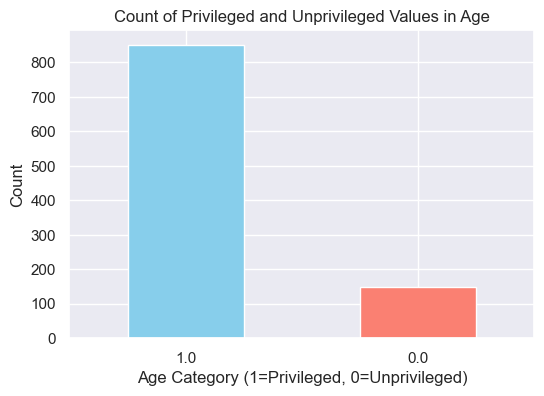

In [78]:
age_counts = df_bank['age'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Age')
plt.xlabel('Age Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [79]:
dataset_orig.label_names

['credit']

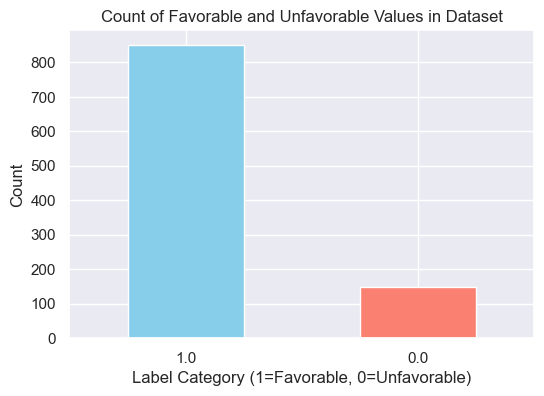

In [80]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['credit'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [81]:
df_bank.shape

(1000, 58)

In [35]:
df_german = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

In [36]:
y_german = dataset_orig.labels.ravel()  # Convert to array-like labels

In [37]:
df_german.shape

(1000, 57)

In [38]:
import collections

In [39]:
collections.Counter(y_german)

Counter({1.0: 700, 0.0: 300})

In [40]:
df_german[y_german == 1][df_german["age"]==1]

C:\Users\ilham\AppData\Local\Temp\ipykernel_3792\1073699377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_german[y_german == 1][df_german["age"]==1]


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,36.0,9055.0,2.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
6,24.0,2835.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,12.0,2390.0,4.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [41]:
from metrics_utils import get_orig_model_metrics
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.97      0.99        39

    accuracy                           0.97        39
   macro avg       0.50      0.49      0.49        39
weighted avg       1.00      0.97      0.99        39

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       132
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92       132
   macro avg       0.50      0.46      0.48      

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 1.0,
 'train_0_1': 0.9743589743589743,
 'train_1_0': 0.9242424242424242,
 'train_1_1': 0.9632107023411371,
 'test_0_0': 0.45161290322580644,
 'test_0_1': 0.5714285714285714,
 'test_1_0': 0.42990654205607476,
 'test_1_1': 0.8242811501597445}

## Display Output

In [42]:
priv_metric_orig_copy = priv_metric_orig

In [43]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 1292.0, 'total_unpriv': 208.0})

In [44]:
priv_metric_orig

defaultdict(float, {'total_priv': 1292.0, 'total_unpriv': 208.0})

In [45]:
priv_metric_orig = priv_metric_orig_copy

1)

german_age
500
2)

              total_priv  total_unpriv
num_instance                          
orig          430.666667     69.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.684667       0.315333    0.700475      0.299525      0.586335   
transf      0.699942       0.300058    0.700475      0.299525      0.697518   

         unpriv_unfavor  
dataset                  
orig           0.413665  
transf         0.302482  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.612272      -0.067101  0.170440      -0.126981   
dt_syn                     0.631166      -0.020892  0.103891      -0.064484   
dt_dir                     0.617972      -0.058138  0.135473      -0.093706   
dt_rew                     0.612812 

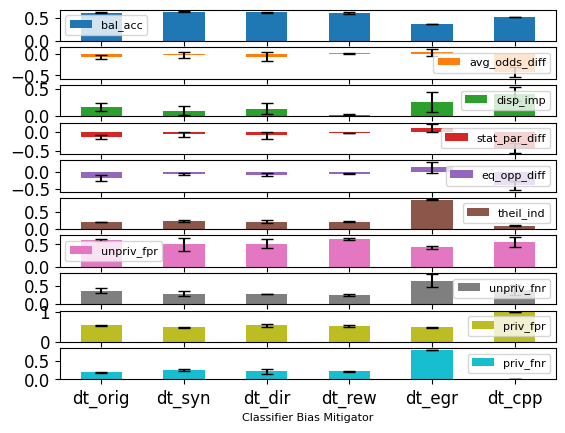

In [46]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

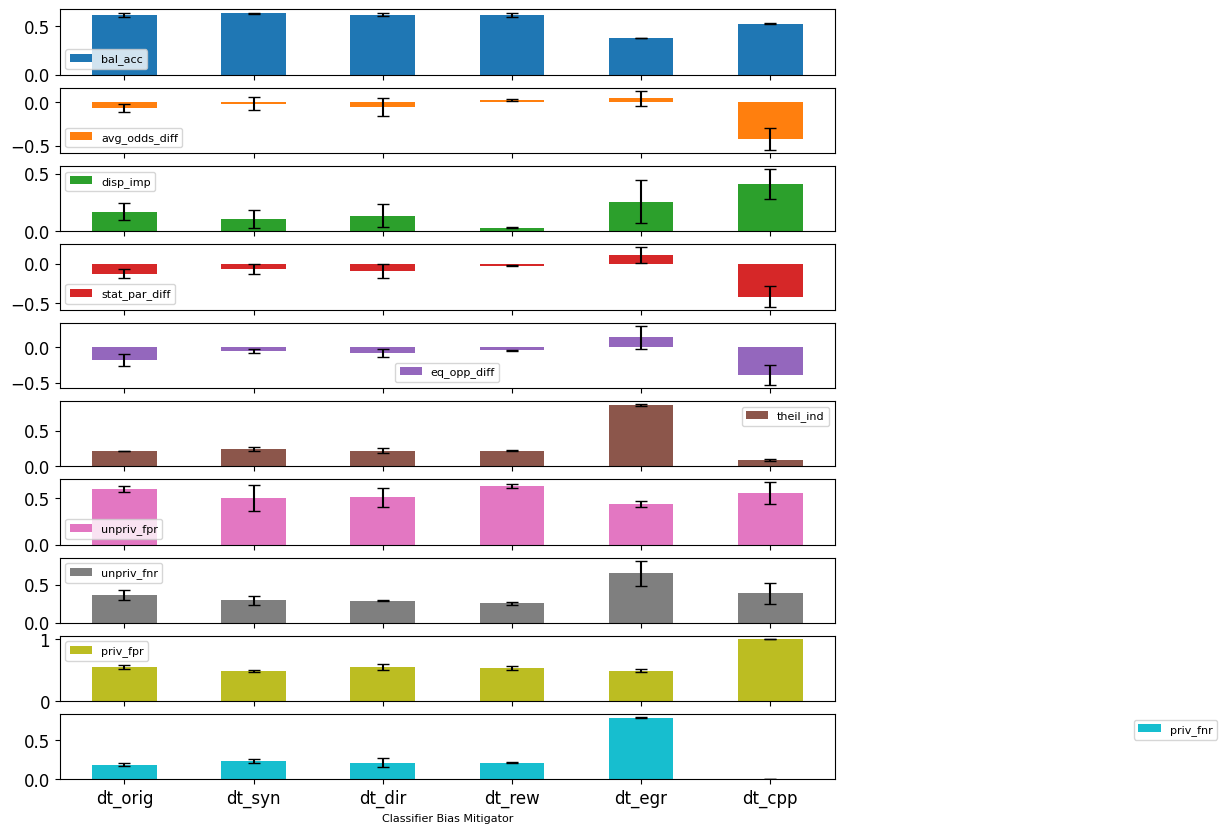

In [47]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [48]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.612272,-0.067101,0.170440,-0.126981,-0.180280,0.213565,0.596621,0.370594,0.550542,0.190314
dt_syn,0.631166,-0.020892,0.103891,-0.064484,-0.053105,0.239779,0.498618,0.293445,0.487297,0.240339
dt_dir,0.617972,-0.058138,0.135473,-0.093706,-0.076789,0.219669,0.510599,0.288961,0.550086,0.212172
dt_rew,0.612812,0.025515,0.031752,-0.022915,-0.041412,0.216565,0.627650,0.254174,0.535208,0.212762
dt_egr,0.375154,0.042855,0.257884,0.105495,0.142922,0.859235,0.434409,0.647650,0.491621,0.790572
dt_cpp,0.524834,-0.418765,0.413608,-0.413608,-0.388683,0.093449,0.551152,0.388683,1.000000,0.000000


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [49]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [50]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.637333,0.725423,0.604833,0.774318,0.707749,0.714006,0.589355
syn,0.638333,0.705769,0.614196,0.693326,0.666956,0.709488,0.611425
dir,0.634333,0.747898,0.593009,0.743342,0.647022,0.751285,0.586630
rew,0.640667,0.723083,0.609890,0.763984,0.657115,0.714669,0.604919
egr,0.698333,0.778404,0.668210,0.797227,0.734486,0.781950,0.657634


In [51]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [52]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [53]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.774318,0.707749,0.714006,0.589355
syn,0.693326,0.666956,0.709488,0.611425
dir,0.743342,0.647022,0.751285,0.586630
rew,0.763984,0.657115,0.714669,0.604919
egr,0.797227,0.734486,0.781950,0.657634


<Axes: xlabel='Classifier MIA Attacks'>

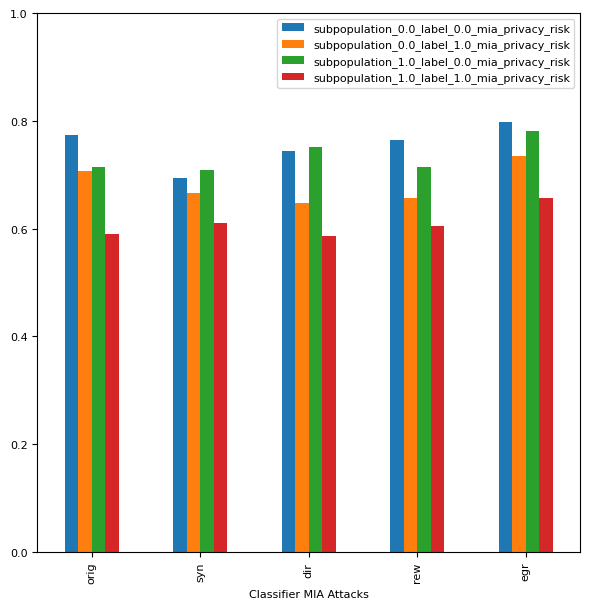

In [54]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [55]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.774318  0.693326  0.743342  0.763984  0.797227
subpopulation_0.0_label_1.0_mia_privacy_risk  0.707749  0.666956  0.647022  0.657115  0.734486
subpopulation_1.0_label_0.0_mia_privacy_risk  0.714006  0.709488  0.751285  0.714669  0.78195
subpopulation_1.0_label_1.0_mia_privacy_risk  0.589355  0.611425  0.58663   0.604919  0.657634


### Visualizing using novel technique

In [56]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [57]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [58]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.632000
1,orig,entire_dataset_mia_privacy_risk,0.640000
2,orig,entire_dataset_mia_privacy_risk,0.640000
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.694520
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.740875
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.830147
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.830147
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.626454
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.673224


In [59]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.632000
1,orig,entire_dataset_mia_privacy_risk,0.640000
2,orig,entire_dataset_mia_privacy_risk,0.640000
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.742308
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.790323
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.830147
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.830147
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.626454
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.673224


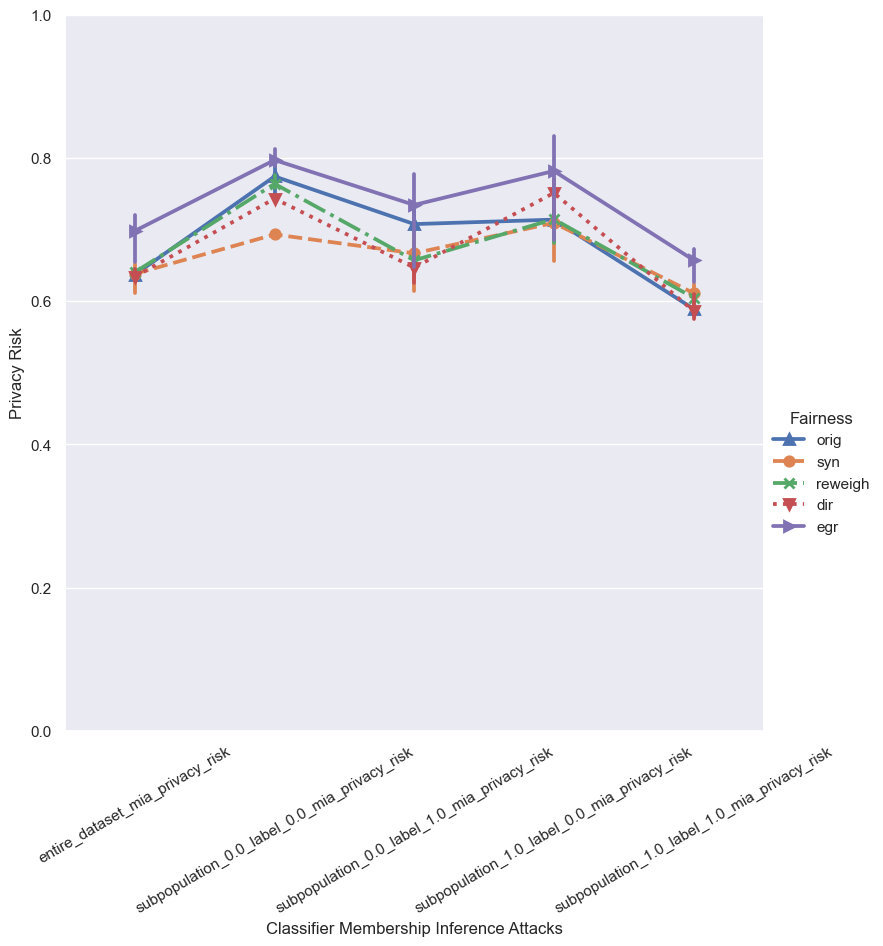

In [60]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [61]:
from sklearn.metrics import RocCurveDisplay, auc

In [62]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

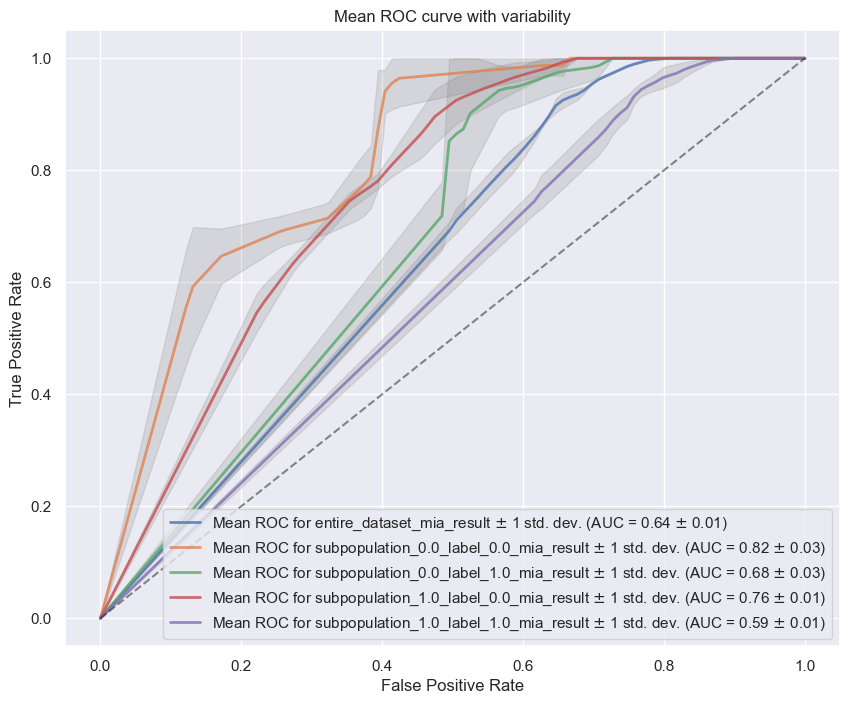

In [63]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

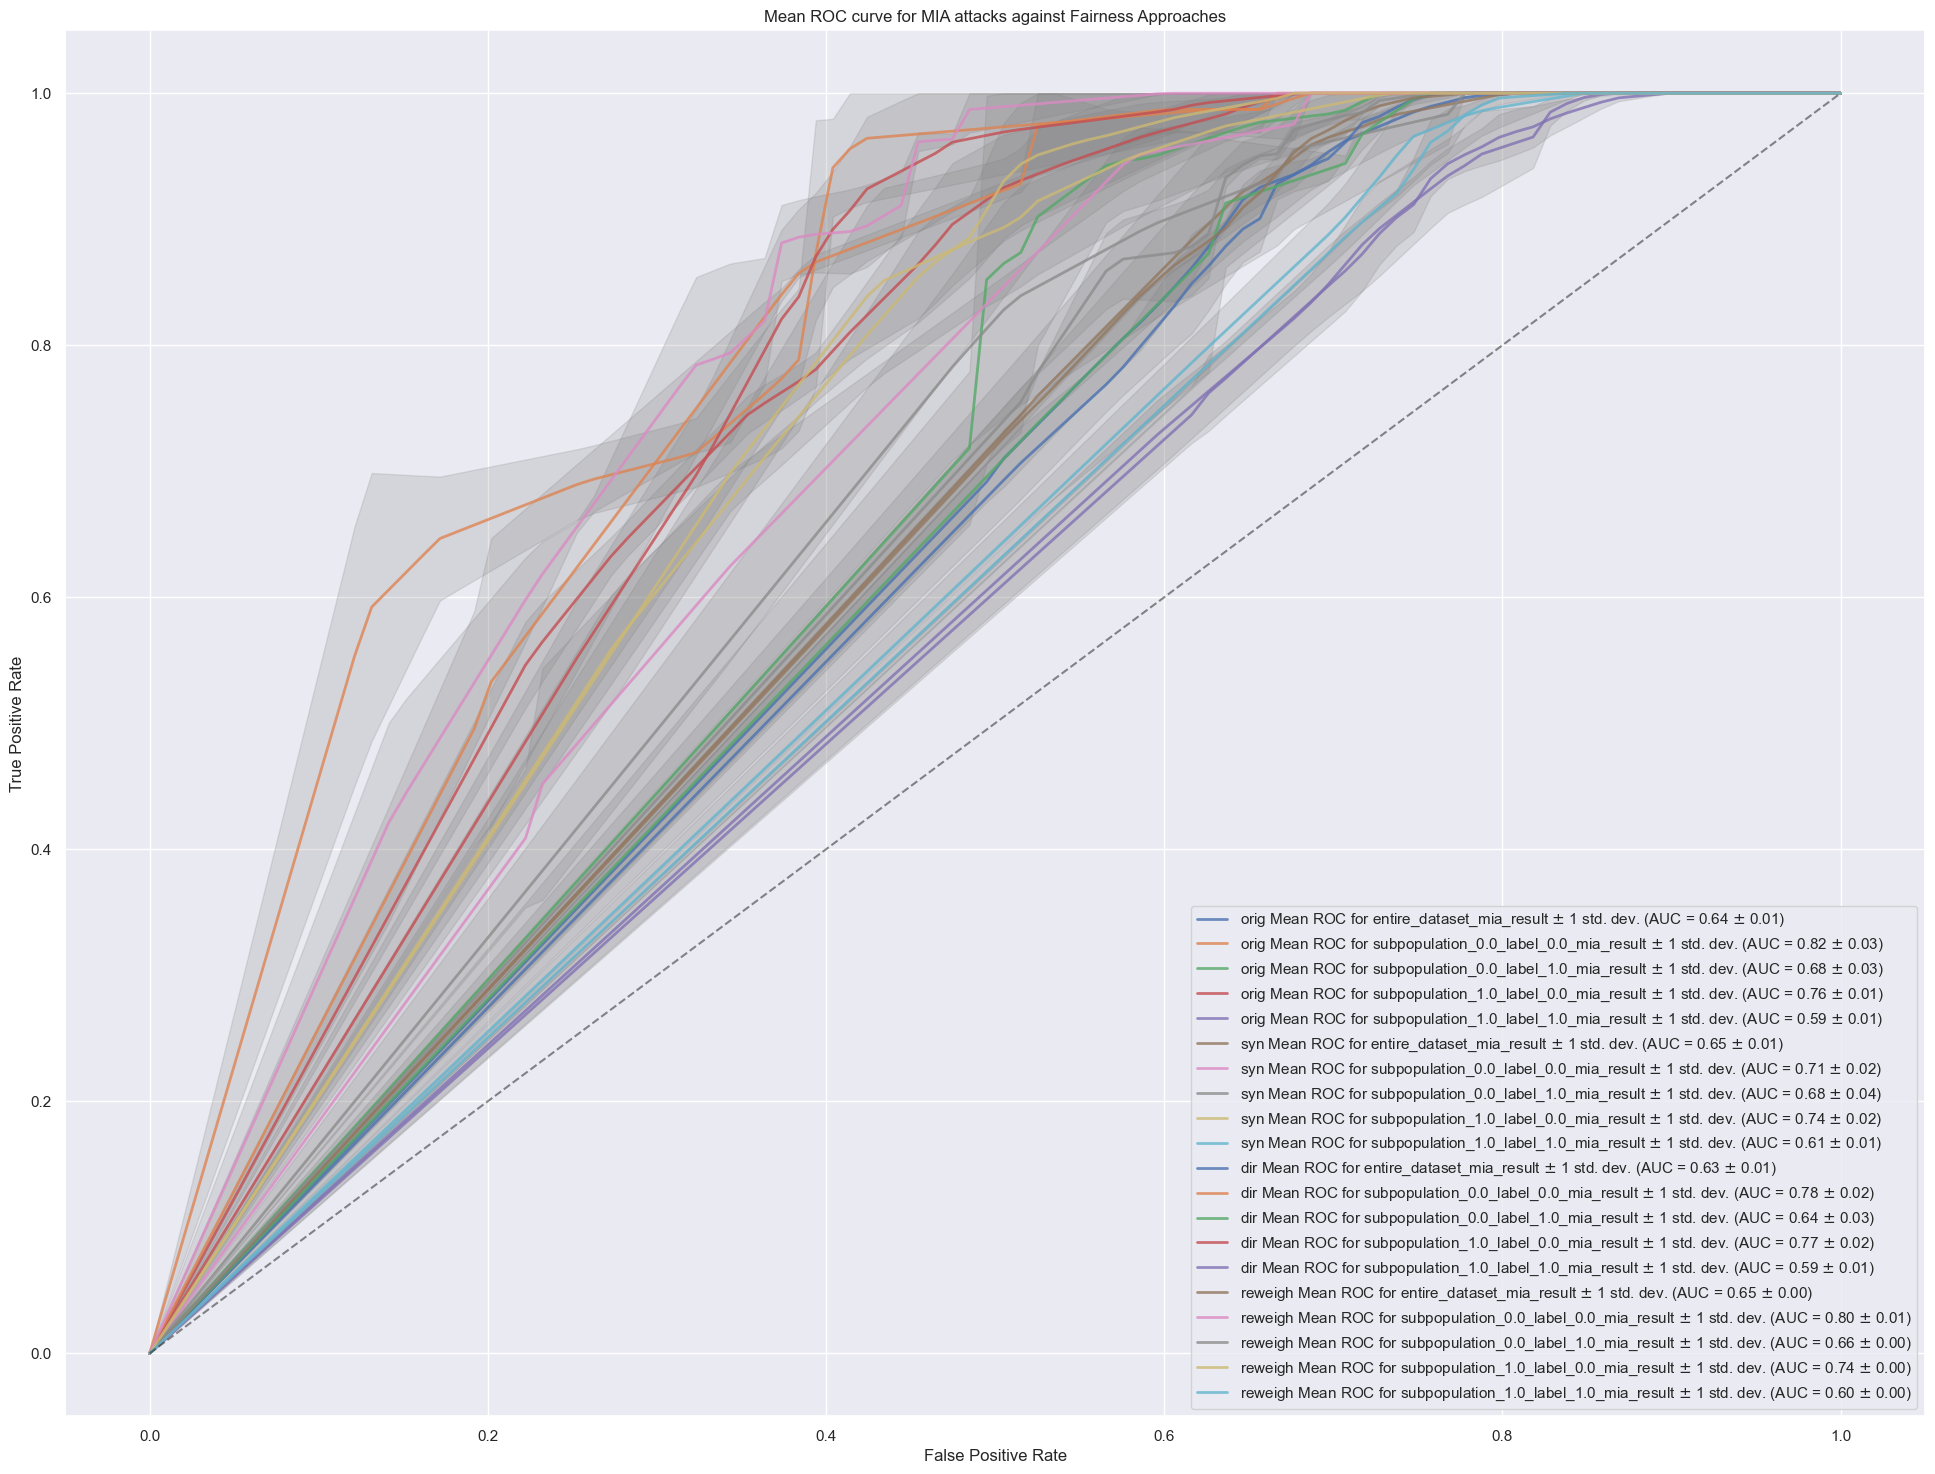

In [64]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

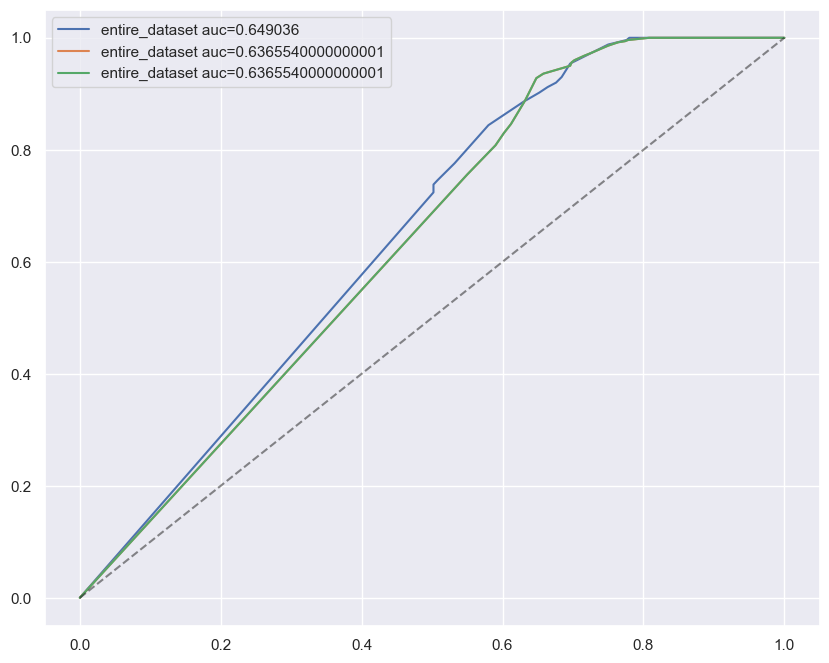

In [65]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [66]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [67]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.6407146666666667,
 'entire_dataset_label_0.0_mia_auc': 0.7747972539328091,
 'entire_dataset_label_1.0_mia_auc': 0.5977288817785679,
 'subpopulation_0.0_label_0.0_mia_auc': 0.8208298869589191,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6752317848097068,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7612435795350834,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5867463852492306}

In [68]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.640715,0.774797,0.597729,0.820830,0.675232,0.761244,0.586746
syn,0.650605,0.732185,0.617992,0.712135,0.683448,0.738173,0.607718
dir,0.635034,0.764637,0.596436,0.778861,0.641639,0.765505,0.589518
rew,0.649568,0.753613,0.608571,0.797721,0.657780,0.740143,0.601197


<Axes: xlabel='Classifier MIA Attacks'>

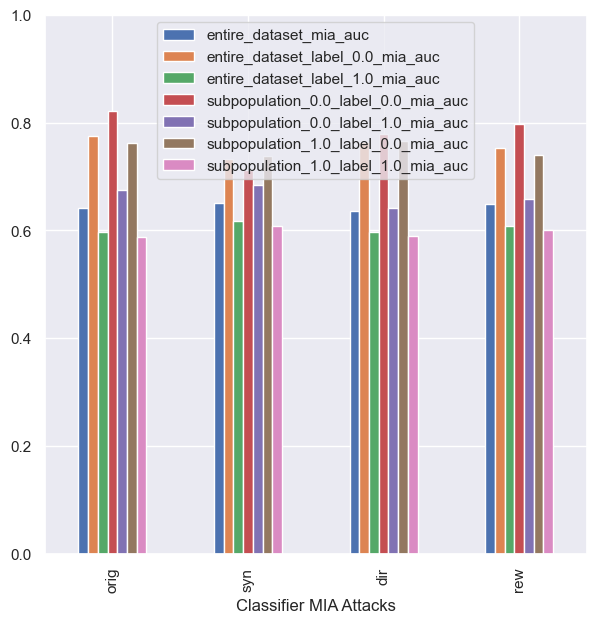

In [69]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [70]:
# Creating data structures to plot point categorical plot from seaborn

In [71]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [72]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.264, 0.28, 0.28],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.3890395128672385,
  0.4817498658078368,
  0.4817498658078368],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.21260581719034444,
  0.20819575664454537,
  0.20819575664454537],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.48461538461538456,
  0.5806451612903225,
  0.5806451612903225],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.3181818181818181,
  0.46415489272632127,
  0.46415489272632127],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.3701289599102888,
  0.456952704616256,
  0.456952704616256],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.19736209750627431,
  0.16938249970615582,
  0.16938249970615582]}

In [73]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.264],
 ['orig', 'entire_dataset', 0.28],
 ['orig', 'entire_dataset', 0.28],
 ['orig', 'entire_dataset_label_0.0', 0.3890395128672385],
 ['orig', 'entire_dataset_label_0.0', 0.4817498658078368],
 ['orig', 'entire_dataset_label_0.0', 0.4817498658078368],
 ['orig', 'entire_dataset_label_1.0', 0.21260581719034444],
 ['orig', 'entire_dataset_label_1.0', 0.20819575664454537],
 ['orig', 'entire_dataset_label_1.0', 0.20819575664454537],
 ['orig', 'subpopulation_0.0_label_0.0', 0.48461538461538456],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5806451612903225],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5806451612903225],
 ['orig', 'subpopulation_0.0_label_1.0', 0.3181818181818181],
 ['orig', 'subpopulation_0.0_label_1.0', 0.46415489272632127],
 ['orig', 'subpopulation_0.0_label_1.0', 0.46415489272632127],
 ['orig', 'subpopulation_1.0_label_0.0', 0.3701289599102888],
 ['orig', 'subpopulation_1.0_label_0.0', 0.456952704616256],
 ['orig', 'subpopulation_1.0_label_0.0'

In [74]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.264000
1,orig,entire_dataset,0.280000
2,orig,entire_dataset,0.280000
3,orig,entire_dataset_label_0.0,0.389040
4,orig,entire_dataset_label_0.0,0.481750
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.660295
101,egr,subpopulation_1.0_label_0.0,0.660295
102,egr,subpopulation_1.0_label_1.0,0.252908
103,egr,subpopulation_1.0_label_1.0,0.346448


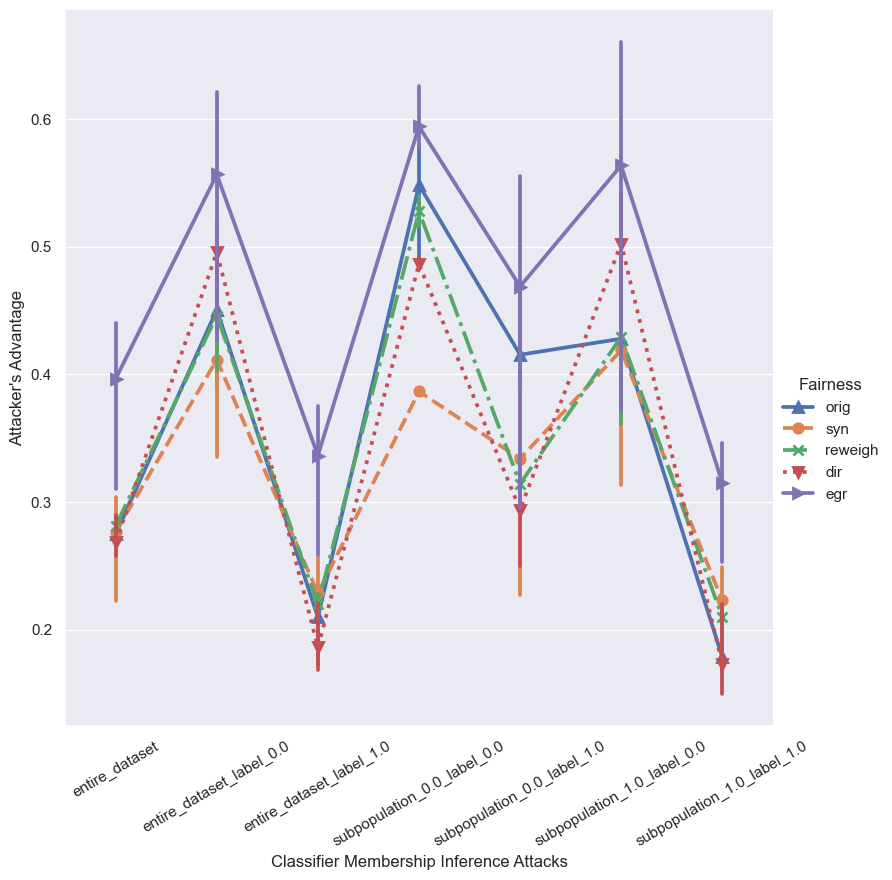

In [75]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


KeyError: 'egr'

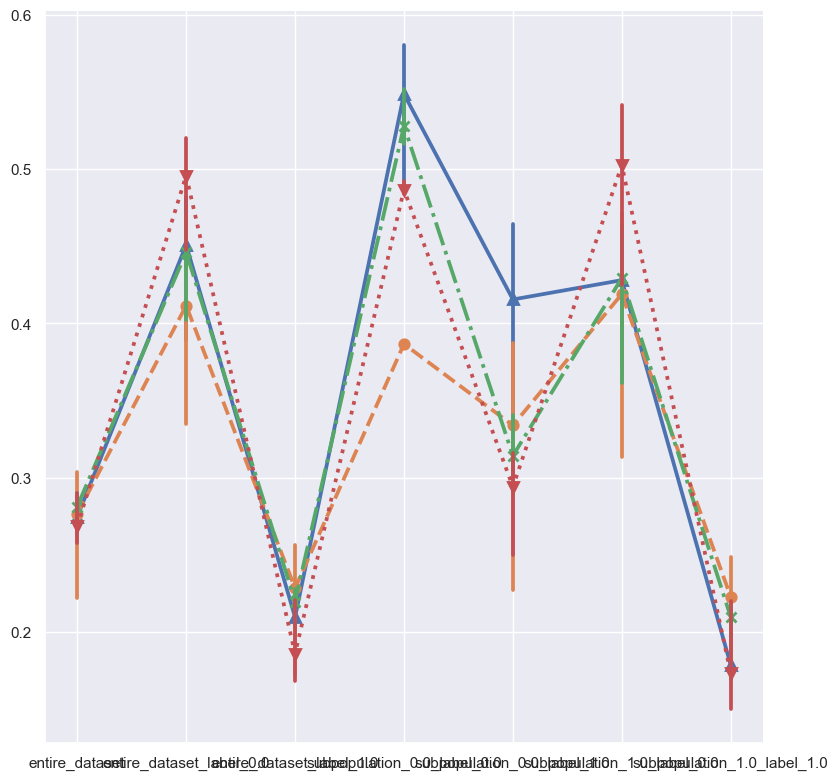

In [76]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()